In [33]:
from dotenv import load_dotenv
import os
load_dotenv()

from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
ASTRA_DB_API_KEY = os.getenv('ASTRA_DB_API_KEY')
ASTRA_DB_ENDPOINT = os.getenv('ASTRA_DB_ENDPOINT')
ASTRA_DB_KEYSPACE = os.getenv('ASTRA_DB_KEYSPACE')

def load_model(model_name: str = "gpt-4o", tools=None):
    """Load the model dynamically based on the parameter."""
    model = ChatOpenAI(
        model=model_name,
        temperature=0,
    )
    # Bind tools if provided
    if tools:
        model = model.bind_tools(tools)
    
    return model


embeddings = OpenAIEmbeddings()

from langchain_community.vectorstores import AstraDB

def get_vectorstore(collection_name: str) -> AstraDB:
    return AstraDB(
    embedding=embeddings,
    token=ASTRA_DB_API_KEY,
    api_endpoint=ASTRA_DB_ENDPOINT,
    collection_name=collection_name,
    )

In [34]:
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name='header',
        description="The 'header' of the page. The 'header' is one of ['Overview', 'Tasks', 'Setup', 'Additional information']",
        type="string",
    ),
]

document_content_description = "The pages"

In [35]:
# Define the retriever tool
#def retriever_tool(return_route: str):
def retriever_tool(query: str, rag_collection: str) -> str:
    """Retrieve documents based on a user query and return context."""
    vector_store = get_vectorstore(rag_collection)
    retriever = vector_store.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={"k": 6, "score_threshold": 0.5},
    )
    retrieved_documents = retriever.invoke(query)
    context = "<br />".join([doc.page_content for doc in retrieved_documents])
    return context
    

def metadata_retriever_tool(query: str, rag_collection: str = "not_metadata") -> str:
    """Retrieve documents based on a user query and return context."""
    vectorstore = get_vectorstore(rag_collection)
    model = load_model()
    retriever = SelfQueryRetriever.from_llm(
    model, 
    vectorstore, 
    document_content_description, 
    metadata_field_info, 
    verbose=True,
    search_kwargs={"k": 10},
    )
    retrieved_documents = retriever.invoke(query)
    context = "<br />".join([doc.page_content for doc in retrieved_documents])
    return context

In [36]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage

system_instructions = """
You are an expert at analyzing pdf documents.
You are going to analyze a pdf document and retrieve the content
"""

query_data = """
Here is the pdf document content you want to analyze:
{pdf_document}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_instructions),
    ("human", query_data),
])

In [37]:
new = prompt.invoke(input={"pdf_document":system_instructions})
new

ChatPromptValue(messages=[SystemMessage(content='\nYou are an expert at analyzing pdf documents.\nYou are going to analyze a pdf document and retrieve the content\n', additional_kwargs={}, response_metadata={}), HumanMessage(content='\nHere is the pdf document content you want to analyze:\n\nYou are an expert at analyzing pdf documents.\nYou are going to analyze a pdf document and retrieve the content\n\n', additional_kwargs={}, response_metadata={})])

## The standard create agent

In [38]:
from typing import Callable, List
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel


def create_agent(prompt: str, tools: List[Callable], parser: BaseModel = None, call_after_tool: bool = True):
    
    def agent(state, config):
        llm = load_model(model_name=state.llm_model_name, tools=tools)
        
        if parser:
            llm = llm.with_structured_output(schema=parser)
        

        prompt = prompt.invoke(input={"pdf_document": "pdf_document"})

        try:
            response = llm.invoke(prompt)
            state.messages.append(response)

            # If tool calls detected, invoke the tools
            if tools_condition(state) == 'tools':
                tool_node = ToolNode(tools)
                response = tool_node.invoke(state)
                #print("tool node response: ", response)
                for tool_message in response['messages']:
                    state.messages.append(tool_message)
                    if tool_message.artifact:
                        # Update state with artifacts
                        state = state.copy(update=tool_message.artifact)
                    
                if call_after_tool:
                    agent(state, config)
                else:
                    return state
                
        except Exception as e:
            state.error_message = f"An error occurred while generating variables: {e}"
            return state
        
        return state

    return agent

## PDF loader

source for choosing of loader:

https://towardsdatascience.com/analyzing-unstructured-pdf-data-w-embedding-models-and-llms-f83ae9a57c2b/

Run the pip install first

In [39]:
#pip install fitz frontend pymupdf

# Graph

1. The user gives a list of structured requirements that the test should contain 
2. A retriever agent that finds the correct pdf(s) based on the requirements from the user
2. A analyzing agent retrieves all the content from each page
3. Make a new test based on the requirements and the retrieved pdf(s)

## Defining the state

1. We need to import all the essentials for running the graph
2. Then we define the properties of the system

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image
from langchain_core.documents import Document
from typing import Annotated, List
from pydantic import BaseModel, Field
import operator
import uuid


GET_PDF_FILES = "get_pdf_files"
GET_PDF_CONTENT = "get_pdf_content"


class Image(BaseModel):
    id: uuid.UUID
    content: str
    page_number: int

class PDF(BaseModel):
    id: uuid.UUID
    documents: Annotated[List[Document], operator.add] = Field(default_factory=list)
    images: Annotated[List[Image], operator.add] = Field(default_factory=list)


class InputState(BaseModel):
    requirements: List[str]
    data_path: str

class AgentState(BaseModel):
    next_agent: str = GET_PDF_FILES
    llm_model_name: str = "gpt-4o-mini"
    pdfs: Annotated[List[PDF], operator.add] = Field(default_factory=list)
    error_message: Annotated[str, operator.add] = ""
    data_path: str = "../../data"
    files: List[str] = Field(default_factory=list)
    chosen_files: List[str] = Field(default_factory=list)
    requirements: List[str] = Field(default_factory=list)

## Creating the retrieiver for the pdf files

In [41]:
import os

files = []

def get_pdf_files(state: AgentState):
    # Load the global files
    global files
    files = []
    try:
        data_path = state.data_path
        #  Get the files in the data directory
        for file in os.listdir(data_path):
            if file.endswith(".pdf"):
                files.append(file)
    except Exception as e:
        state.error_message = f"An error occurred while retrieving the files: {e}"
        return state
    
    state.files = files
    return state

## Creating the agent for retriving the correct pdf

In [42]:
################# Our custom retriever prompt ######################

from langchain_core.prompts import ChatPromptTemplate

system_instructions = """
You are an expert at retriving the correct pdfs based on some requirements from the user.
Analyze the requirements and retrieve the correct pdfs and find the correct pdf.
There are following pdfs you can retrieve content from:
examples:
    user: Here is my requirements: ['requirement1', 'requirement2']
    ai-agent: [file.pdf, file2.pdf]

    user: Here is my requirements: ['requirement1', 'requirement2', 'requirement3']
    ai-agent: [file.pdf]
"""

query_data = """
Here are the pdf files you can retrieve:
{files}

Which files do you want to retrieve content from given theese requirements: 
{requirements}
"""

retrieve_prompt = ChatPromptTemplate.from_messages([
    ("system", system_instructions),
    ("human", query_data),
])

################# Our custom function for retriving pdf content ######################

import fitz

def get_pdf_content(pdf_path: str) -> dict:
    pdf_document = fitz.open(pdf_path)
    text = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text.append(page.get_text())
    return text


################# Our custom agent ######################

class RetrieverOutput(BaseModel):
    pdf_files: List[str]

RETRIEVER_AGENT = "retriever_agent"


def create_retrieve_agent(chat_prompt: str, parser: BaseModel = None):
    
    def agent(state):
        llm = load_model(model_name=state.llm_model_name)
        # Makes the prompt template with the values from the state
        prompt = chat_prompt.invoke(input={
            "files": state.files,
            "requirements": state.requirements
            })

        llm_with_structured_output = llm.with_structured_output(schema=parser)
        try:
            response = llm_with_structured_output.invoke(prompt)
            chosen_files = response.pdf_files
            state.chosen_files = chosen_files

            if len(chosen_files) == 0:
                state.error_message = "No files were chosen."
                state.next_agent = END
            else:
                state.next_agent = GET_PDF_CONTENT
            
        except Exception as e:
            state.error_message = f"An error occurred while generating variables: {e}"
            return state
        return state

    return agent

retriever_agent = create_retrieve_agent(
    chat_prompt=retrieve_prompt,
    parser=RetrieverOutput,
)

In [ ]:
import base64
import io
import fitz
from PIL import Image as PILImage

def pdf_page_to_base64(pdf_path: str, page_number: int) -> str:
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = PILImage.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def get_pdf_content(pdf_path: str) -> List[Document]:
    pdf_document = fitz.open(pdf_path)
    documents = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        page_content = page.get_text()
        document = Document(
            page_content=page_content,
            metadata={"source": pdf_path, "page_number": page_num + 1}
        )
        documents.append(document)
    return documents

def get_pdf_content_agent(state: AgentState) -> AgentState:
    pdf_path = state.data_path
    files = state.chosen_files
    for file in files:
        pdf_content = get_pdf_content(f"{pdf_path}/{file}")
        images = []
        for page_num in range(len(pdf_content)):
            image_content = pdf_page_to_base64(f"{pdf_path}/{file}", page_num + 1)
            image = Image(id=uuid.uuid4(), content=image_content, page_number=page_num + 1)
            images.append(image)
        pdf = PDF(id=uuid.uuid4(), documents=pdf_content, images=images)
        state.pdfs.append(pdf)
    print("pdfs: ", state.pdfs)
    return state

In [44]:
builder = StateGraph(AgentState)

builder.add_node(GET_PDF_FILES, get_pdf_files)
builder.add_node(RETRIEVER_AGENT, retriever_agent)
builder.add_node(GET_PDF_CONTENT, get_pdf_content_agent)

builder.add_edge(START, GET_PDF_FILES)
builder.add_edge(GET_PDF_FILES, RETRIEVER_AGENT)
builder.add_edge(RETRIEVER_AGENT, GET_PDF_CONTENT)
builder.add_edge(GET_PDF_CONTENT, END)


memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

print(graph.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	get_pdf_files(get_pdf_files)
	retriever_agent(retriever_agent)
	get_pdf_content(get_pdf_content)
	__end__([<p>__end__</p>]):::last
	__start__ --> get_pdf_files;
	get_pdf_content --> __end__;
	get_pdf_files --> retriever_agent;
	retriever_agent --> get_pdf_content;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



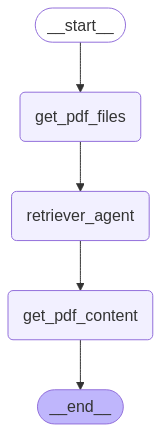

None


In [45]:
print(display(Image(graph.get_graph().draw_mermaid_png())))

## Running the graph

In [46]:
config = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
        }}


def run_client(requirements: list[str], config: dict[str, dict[str, str]] = config) -> AgentState:
    print("### Start Client ###\n")

    state = InputState(
    requirements=requirements,
    data_path="../../data",

    )

    output_state = graph.invoke(state, config)

    if error := output_state.get("error_message"):
        print("\n🙈", error)

    return output_state


In [47]:
query = "I want to retrieve the test with images"

requirements = [query] 

run_client(requirements=requirements)

### Start Client ###



pdfs:  [PDF(id=UUID('43a581a7-4c38-4558-875a-641a4b9d1666'), documents=[Document(metadata={'source': '../../data/test_with_images.pdf', 'page_number': 1}, page_content='DISXRA Rental Agreement to Invoice.docx \n \nPage  1 \n \nRental Agreement to Invoice \nRental is a supplementary revenue stream for distribution companies. Customers can be professionals with an \nexisting customer number, or they can be walk-in customers. A daily rate will be charged for the number of days \nthe items were at the customer’s site. The agreements tend to have a short validity period, often only a few days. \nA rental agreement is a combination of two distribution orders: \n \n \n \nCustomers can either pay directly (cash) via the cash desk, or they can pay against a rental invoice (credit). Two \nrental agreement order types are defined for that purpose: \n• \nCO1 – Cash via the cash desk: immediate payment of the rental deposit or the entire rental invoice as an \nadvance invoice. The customer’s paymen

{'next_agent': 'get_pdf_content',
 'pdfs': [PDF(id=UUID('43a581a7-4c38-4558-875a-641a4b9d1666'), documents=[Document(metadata={'source': '../../data/test_with_images.pdf', 'page_number': 1}, page_content='DISXRA Rental Agreement to Invoice.docx \n \nPage  1 \n \nRental Agreement to Invoice \nRental is a supplementary revenue stream for distribution companies. Customers can be professionals with an \nexisting customer number, or they can be walk-in customers. A daily rate will be charged for the number of days \nthe items were at the customer’s site. The agreements tend to have a short validity period, often only a few days. \nA rental agreement is a combination of two distribution orders: \n \n \n \nCustomers can either pay directly (cash) via the cash desk, or they can pay against a rental invoice (credit). Two \nrental agreement order types are defined for that purpose: \n• \nCO1 – Cash via the cash desk: immediate payment of the rental deposit or the entire rental invoice as an \nad

In [16]:
state_values = graph.get_state(config=config).values
state_values

{'next_agent': 'get_pdf_content',
 'pdfs': [PDF(id=UUID('64686e66-f8ec-4482-89a9-c285c5ff064f'), documents=[Document(metadata={'source': '../../data/UNVXIS.05 Enable Internal Sales Orders.pdf', 'page_number': 1}, page_content=' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \nEnable Internal \nSales Orders \nUNVXIS.05 \nApplication: Infor M3 \nProcess: Internal Sales Orders \n \n \n'), Document(metadata={'source': '../../data/UNVXIS.05 Enable Internal Sales Orders.pdf', 'page_number': 2}, page_content='Enable Internal Sales Orders (Internal Sales Orders) \n2 (13) \nTable of contents \nOVERVIEW ............................................................................................................................... 3 \nCONCEPT ................................................................................................................................. 3 \nPROCESS .......................................................................................................................

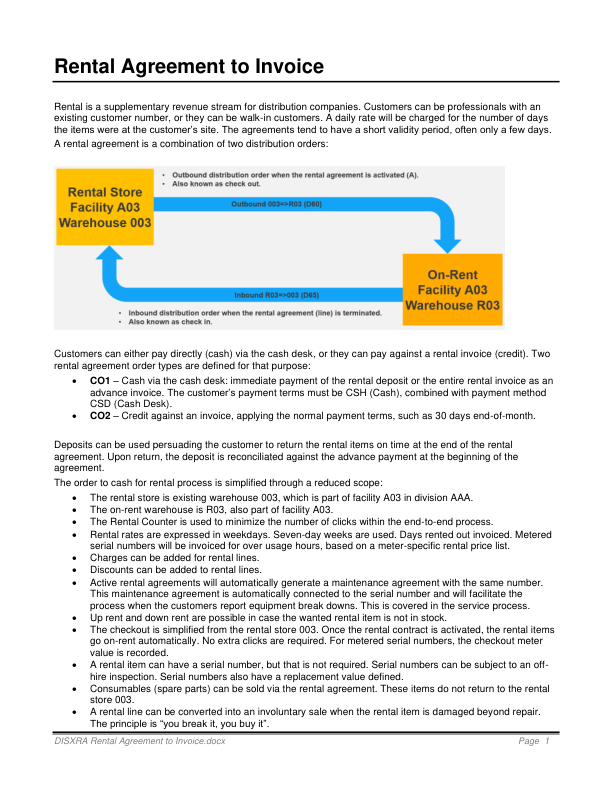

Page 1 analysis:
The document titled "Rental Agreement to Invoice" outlines the framework for a rental system utilized by distribution companies. Here’s a breakdown of the main points:

### Overview
- **Purpose**: Rental serves as a supplementary revenue stream for distribution companies, accommodating both existing customers and walk-ins.
- **Charges**: A daily rate is applied for the duration the items are rented.

### Rental Agreement Types
1. **CO1 (Cash)**: 
   - Immediate payment required at the cash desk. 
   - Payment terms are strict (CSH and CSD).
   
2. **CO2 (Credit)**:
   - Payment is made against a rental invoice, following standard payment terms (e.g., net 30).

### Features of the Rental Process
- **Deposits**: Customers may provide deposits to ensure timely return of rental items. These are reconciled on return.
- **Warehouse Structure**:
  - **Rental Store**: Warehouse 003, part of facility A03.
  - **On-Rent Warehouse**: Warehouse R03, also in facility A03.
- **Strea

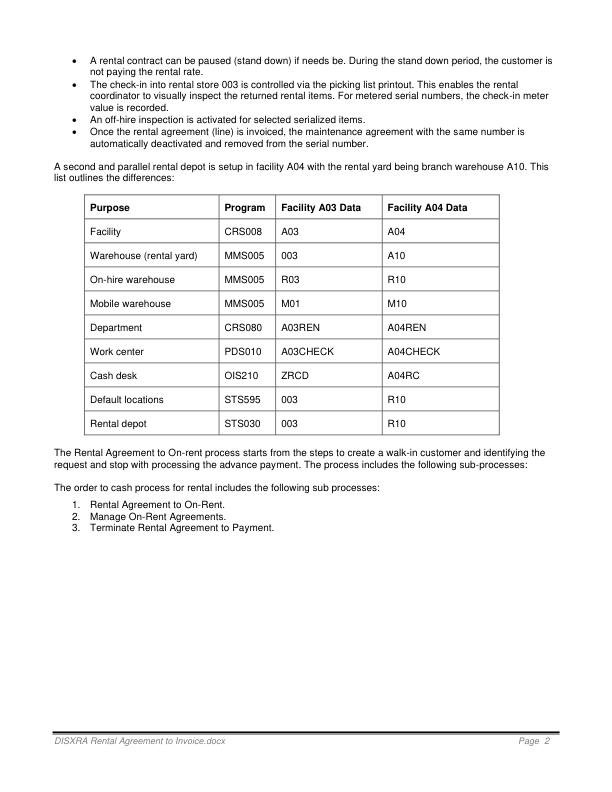

KeyboardInterrupt: 

In [17]:
import base64
import io
import fitz
from PIL import Image
from IPython.display import Image as IPImage, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def get_pdf_content(pdf_path: str) -> dict:
    pdf_document = fitz.open(pdf_path)
    text = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        text.append(page.get_text())
    return text

# Get the content of the PDF file
pdf_text = get_pdf_content("../../data/test_with_images.pdf")

# Path to the PDF file
pdf_path = "../../data/test_with_images.pdf"

# Initialize the multimodal model
llm = ChatOpenAI(model="gpt-4o-mini")

# Iterate over each page and analyze content
for page_num, page_text in enumerate(pdf_text, start=1):
    # Convert the page to a base64 image
    base64_image = pdf_page_to_base64(pdf_path, page_num)
    display(IPImage(data=base64.b64decode(base64_image)))

    # Define the query
    query = f"Analyze the content of page {page_num}"

    # Create the message with text and image
    message = HumanMessage(
        content=[
            {"type": "text", "text": query},
            {"type": "text", "text": page_text},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
        ],
    )

    # Query the model
    response = llm.invoke([message])
    print(f"Page {page_num} analysis:\n{response.content}\n")

In [ ]:
pdf_text = get_pdf_content(pdf_path)
pdf_text

['DISXRA Rental Agreement to Invoice.docx \n \nPage  1 \n \nRental Agreement to Invoice \nRental is a supplementary revenue stream for distribution companies. Customers can be professionals with an \nexisting customer number, or they can be walk-in customers. A daily rate will be charged for the number of days \nthe items were at the customer’s site. The agreements tend to have a short validity period, often only a few days. \nA rental agreement is a combination of two distribution orders: \n \n \n \nCustomers can either pay directly (cash) via the cash desk, or they can pay against a rental invoice (credit). Two \nrental agreement order types are defined for that purpose: \n• \nCO1 – Cash via the cash desk: immediate payment of the rental deposit or the entire rental invoice as an \nadvance invoice. The customer’s payment terms must be CSH (Cash), combined with payment method \nCSD (Cash Desk). \n• \nCO2 – Credit against an invoice, applying the normal payment terms, such as 30 days e